Dog Breed
Due July 22, 2022 5:30 PM
Instructions
Use the dog breed dataset : https://www.kaggle.com/c/dog-breed-identification

- Create a notebook containing the following analysis:
- Check / adjust data quality
- Extract features from images
- Reduce dimensionality
- Classify dogs per breeds

-Once you are done with these 4 points, use a CNN instead and compare results with your previous solution.


# Environment Setup

In [2]:
import os
import cv2
import tqdm
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")                   # Suppressing Jupyter Notebook Warnings
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# DataSet Gathering

In [3]:
# Importing the labels dataset
labels_csv = pd.read_csv('data/dog-breed-identification/labels.csv')

# Viewing the head of the dataset
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# Saving the training dataset path to a variable
train_path = "data/dog-breed-identification/train/"

# Creating image paths from the name
filenames = [train_path + fname + ".jpg" for fname in labels_csv['id']]

# Viewing the first 10 filenames
filenames[:10]


['data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [5]:
# Checking whether the number of filenames in the directory matches to that of ours
print(len(os.listdir(train_path)) == len(filenames))

True


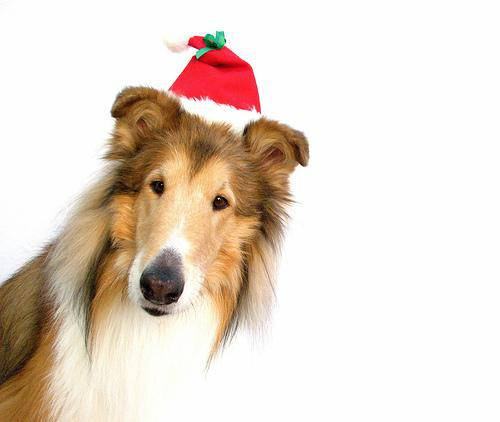

In [8]:
# Viewing an image using filename
Image("data/dog-breed-identification/train/0a6c192b96e55e2ca37318919b1ffae6.jpg")

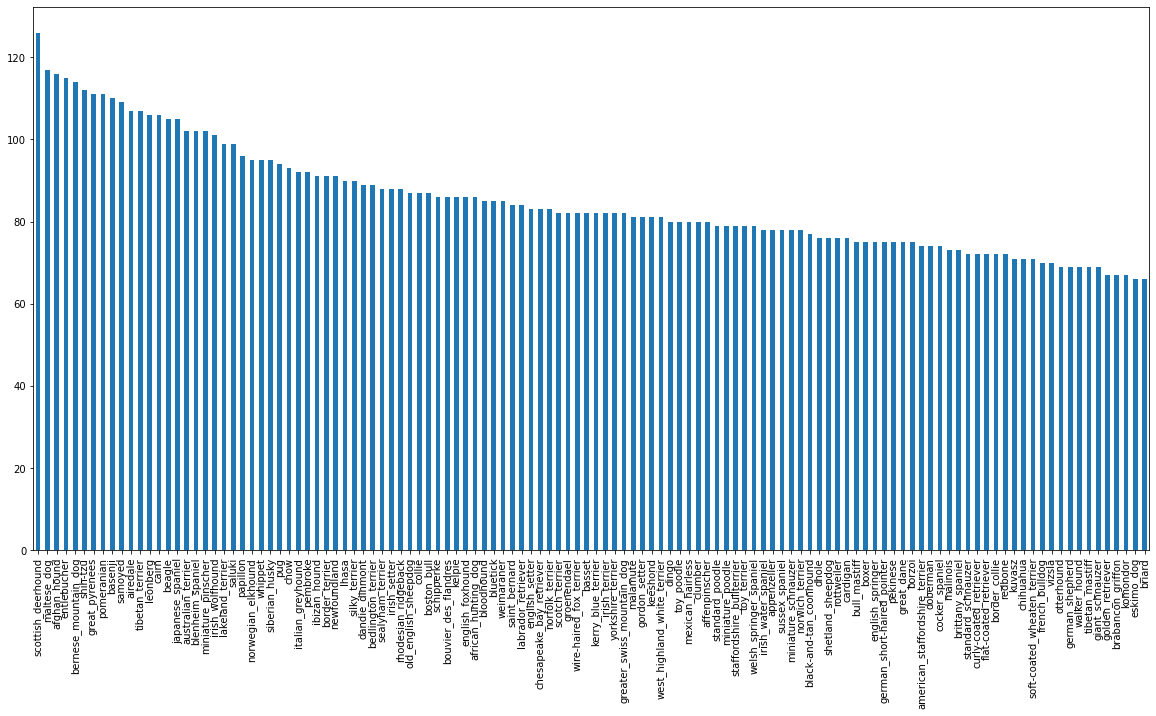

In [9]:
# Visualizing the distribution of images accoding to class
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

# 4. Data Preprocessing:
---
> In this step, we have cleaned the data thus obtained for the previous steps before splitting them into training and testing datasets. We have also cleaned the images obtained by reshaping their shapes and changing their color changes.

In [10]:
# Converting the label columns to Numpy array
labels = labels_csv['breed'].to_numpy()

# Viewing the first 10 labels
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [11]:
# Saving the count of total number of unique breeds to a variabkle
unique_breeds = np.unique(labels)

print("Total number of unique breeds : ", len(unique_breeds))

Total number of unique breeds :  120


In [14]:
# Converting the labels to a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]

# Viewing how it looks like
boolean_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
# Creating training and validation sets

# Separating the features and labels
X = filenames
y = boolean_labels

print(f"Number of training images: {len(X)}")
print(f"Number of labels: {len(y)}")

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

print(f"Number of training images : {len(X_train)}")
print(f"Number of validation images : {len(X_val)}")

Number of training images: 10222
Number of labels: 10222
Number of training images : 8177
Number of validation images : 2045


#### Image Preprocessing:

> In this step, we have resized and reshaped the images and we have also changed their color changes.

In [17]:
# Reading an image in and checking shape
image = plt.imread(filenames[42])
print(f"Image Shape : {image.shape}")

# Converting the image to a Tensorflow Tensor
tf.constant(image)

Image Shape : (257, 350, 3)
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-30 11:39:10.214418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-30 11:39:10.218846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [18]:
# Setting the Image Size
IMAGE_SIZE = 224

# Creating a function to preprocess the images
def process_image(image_path):
    
    # Read in the image
    image = tf.io.read_file(image_path)
    
    # Turn the image into numerical tensors
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Convert the color channel values from 0-225 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    
    return image

#### Batching the Data:
> Here, we have created batches after processing the images with their labels for faster and effective training.

In [19]:
# Creating a function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [20]:
# Setting the batch size at 32 
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Function to batch the data
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
  
    # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels
    
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [23]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [24]:
# Checking the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# 5. Model Evaluation:
---
> In this step, we have chosen the ResNet50V2 as it poses the most performance in problems such as these. To squeeze out even more performance in this case, we have used Adam optimizer and Categorical Cross Entropy.

In [25]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, colour channels

# Model URL for ResNet50V2
MODEL_URL = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

# Creating the model for ResNet50V2
model = tf.keras.Sequential([
    # Layer 1 : Input Layer
    hub.KerasLayer(MODEL_URL),
    
    # Layer 2 : Output Layer
    tf.keras.layers.Dense(120, activation='softmax')
])

# Compiling the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Building the model
model.build(INPUT_SHAPE)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              25612201  
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 25,732,441
Trainable params: 120,240
Non-trainable params: 25,612,201
_________________________________________________________________


In [27]:
# Creating Tensorflow EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# Fitting the model
hist = model.fit(train_data, epochs=1, validation_data=val_data, callbacks=[early_stopping])

256/256 [==============================] - 107s 418ms/step - loss: 3.7545 - accuracy: 0.8481 - val_loss: 3.6735 - val_accuracy: 0.8533


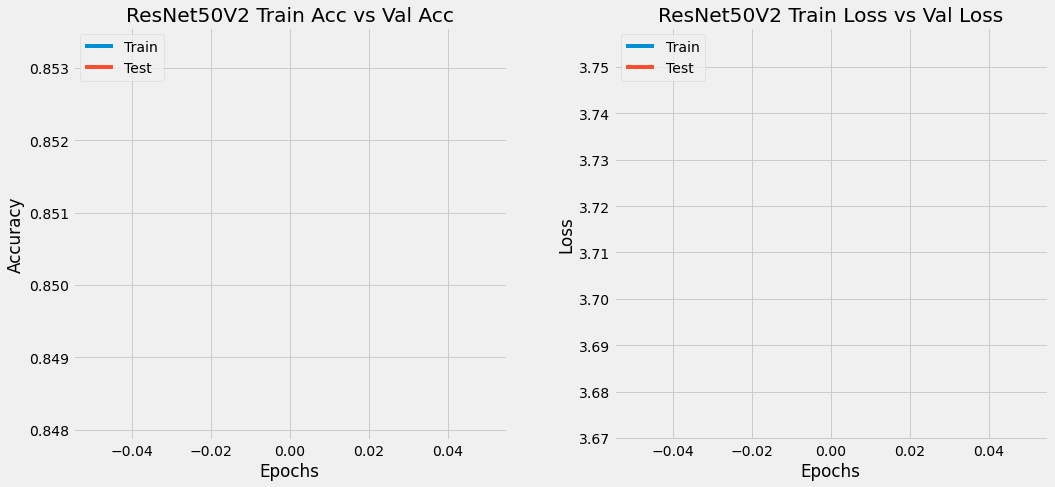

In [30]:
# Creating graphs to visualize the accuracy and loss for the models
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16, 8), squeeze=False)

fig.tight_layout(pad=5)

plt.style.use('fivethirtyeight')

# Graph for ResNet50V2 Training Accuracy vs Validation Accuracy
axes[0][0].plot(hist.history['accuracy'])
axes[0][0].plot(hist.history['val_accuracy'])
axes[0][0].set_ylabel("Accuracy")
axes[0][0].set_xlabel("Epochs")
axes[0][0].set_title('ResNet50V2 Train Acc vs Val Acc')
axes[0][0].legend(['Train', 'Test'], loc='upper left')

# Graph for ResNet50V2 Training Loss vs Validation Loss
axes[0][1].plot(hist.history['loss'])
axes[0][1].plot(hist.history['val_loss'])
axes[0][1].set_ylabel("Loss")
axes[0][1].set_xlabel("Epochs")
axes[0][1].set_title('ResNet50V2 Train Loss vs Val Loss')
axes[0][1].legend(['Train', 'Test'], loc='upper left')

In [29]:
# Making predictions
predictions = model.predict(val_data, verbose=2)

# Viewing the predictions
predictions[0]

2022-06-30 12:02:38.402283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 - 25s - 25s/epoch - 397ms/step


array([0.00730274, 0.0078791 , 0.00688172, 0.00819881, 0.0073203 ,
       0.00907112, 0.01367435, 0.0181637 , 0.00750862, 0.00799481,
       0.00666351, 0.0088853 , 0.00798016, 0.00783989, 0.00701698,
       0.00745919, 0.00733118, 0.00750283, 0.00704645, 0.01590287,
       0.0071781 , 0.00695285, 0.00939411, 0.00672391, 0.00717271,
       0.00736577, 0.00786483, 0.00844541, 0.00744875, 0.01602392,
       0.00779736, 0.00716259, 0.00613541, 0.00727124, 0.00634016,
       0.00675943, 0.00740423, 0.00907586, 0.0136638 , 0.00835219,
       0.00744635, 0.00727487, 0.00825764, 0.00632927, 0.00620003,
       0.00900925, 0.00607906, 0.00667306, 0.00660977, 0.00697236,
       0.0078386 , 0.00693336, 0.00846949, 0.00700194, 0.00683062,
       0.00747215, 0.00761841, 0.00700576, 0.00747766, 0.00774726,
       0.01593184, 0.00883386, 0.00775656, 0.01058084, 0.00793476,
       0.0058547 , 0.00736535, 0.0067025 , 0.00729954, 0.00774509,
       0.00690777, 0.0072071 , 0.0068307 , 0.00875275, 0.01128